In [1]:
import os
import re
import json
import glob
import datetime
from collections import Counter
import itertools
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import IPython.display
from IPython.display import display

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# plt.rc('font', serif='Times New Roman', family='serif', size=12.0)

In [4]:
def tokenize(s):
    s = re.sub(r'[^\w]', ' ', s)
    return s.lower().strip().split()

In [5]:
def read_lines(filepaths):
    for filepath in filepaths:
        with open(filepath) as fp:
            for line in fp:
                yield line

In [6]:
def speeches_to_counts(speeches):
    tokens = [token for speech in speeches for token in tokenize(speech['text'])]
    return Counter(tokens)

In [7]:
stopwords_filepath = '/usr/local/Cellar/postgresql/9.6.1/share/postgresql/tsearch_data/english.stop'
stopwords = [line.strip() for line in open(stopwords_filepath)]

In [8]:
def read_inaugural():
    for line in read_lines(['../data/millercenter/speeches.json']):
        speech = json.loads(line)
        if 'Inaugural' in speech['title']:
            yield speech

In [9]:
pretrump_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
                                               if 'Trump' not in speech['author'])
print '# tokens:', sum(pretrump_inaugural_counts.values())

# tokens: 130081


In [10]:
postwar_pretrump_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
                                                       if speech['timestamp'] > '1948-11-01' 
                                                       and 'Trump' not in speech['author'])
print '# tokens:', sum(postwar_pretrump_inaugural_counts.values())
# print 'top 50 types:', postwar_pretrump_inaugural_counts.most_common(50)

# tokens: 32210


In [11]:
def read_trump_election2016():
    for line in read_lines(['../data/tapp/election2016.json']):
        speech = json.loads(line)
        title = speech['title']
        press_release = title.startswith('Press Release')
        statement = 'Statement by' in title
        if not press_release and not statement and speech['author'] == 'Donald J. Trump':
            yield speech

In [12]:
trump_election2016_counts = speeches_to_counts(read_trump_election2016())
print '# tokens:', sum(trump_election2016_counts.values())
# print 'top 50 types:', trump_election2016_counts.most_common(50)

# tokens: 163681


In [13]:
synsets = [
    ('freedom(s)', ['freedom', 'freedoms']),
    ('justice', ['justice']),
    ('liberty(ies)', ['liberty', 'liberties']),
    ('rights', ['rights']),
    ('america(n/s)', ['america', 'americans', 'american']),
    ('jobs(s)', ['job', 'jobs']),
]

In [14]:
def proportional_usage(tokens, counts):
    maximum = sum(counts.values())
    usage = sum(counts.get(token, 0) for token in tokens)
    return float(usage) / float(maximum)

def synset_proportional_usages(synsets, counts):
    return {synset_name: proportional_usage(synset_tokens, counts) for synset_name, synset_tokens in synsets}

In [15]:
def iter_usages():
    sources = [('All pre-Trump inaugural speeches', pretrump_inaugural_counts),
               ('Post-war, pre-Trump inaugural speeches', postwar_pretrump_inaugural_counts),
               ('Trump campaign speeches', trump_election2016_counts)]
    for source_name, source_counts in sources:
        for synset_name, synset_tokens in synsets:
            usage = proportional_usage(synset_tokens, source_counts)
            yield dict(source=source_name, synset=synset_name, usage=usage)

In [16]:
df_usages = pd.DataFrame.from_dict(iter_usages())

In [17]:
df_usages_t = df_usages.pivot(index='synset', columns='source', values='usage')
df_usages_t

source,All pre-Trump inaugural speeches,"Post-war, pre-Trump inaugural speeches",Trump campaign speeches
synset,,,
america(n/s),0.003052,0.007979,0.010154
freedom(s),0.001345,0.003539,0.000128
jobs(s),0.000100,0.000373,0.004515
justice,0.000953,0.000962,0.000403
liberty(ies),0.000992,0.001397,0.000079
rights,0.000999,0.000683,0.000147


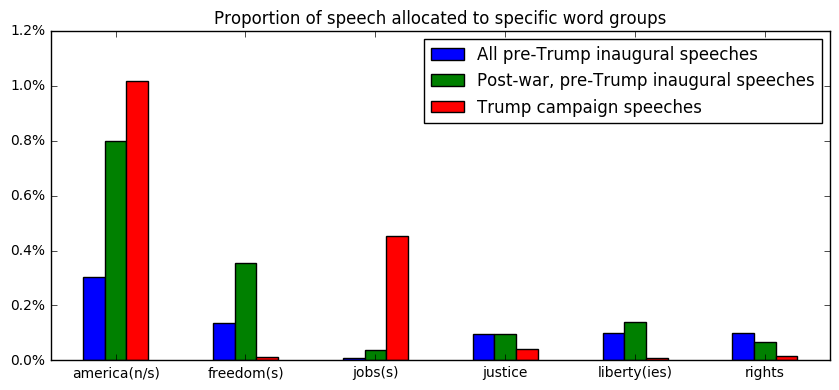

In [19]:
ax = df_usages_t.plot(figsize=(8.5, 4), kind='bar')
ax.xaxis.label.set_visible(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.01%}'.format(y))) 
legend = ax.legend()
legend.set_title(None)
plt.xticks(rotation=0)
plt.title('Proportion of speech allocated to specific word groups')
plt.tight_layout()
# plt.savefig('grouped_proportions.pdf')

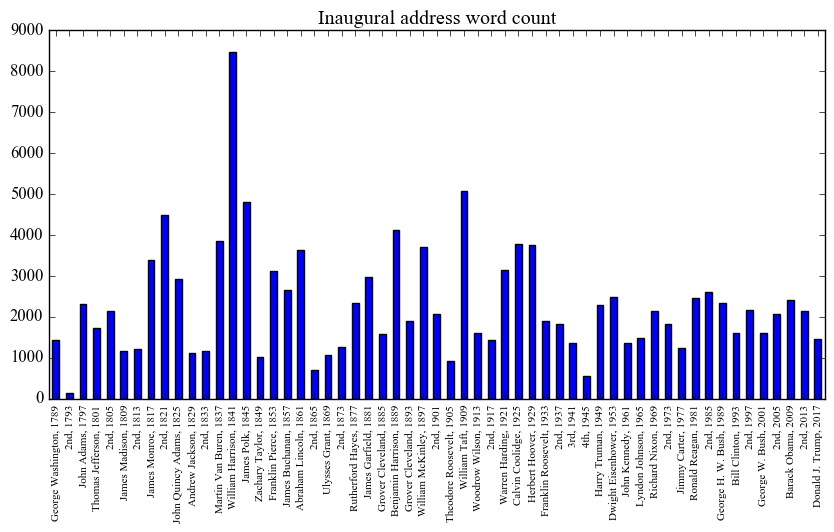

In [680]:
ordinal_mapping = {'First': '1st', 'Second': '2nd', 'Third': '3rd', 'Fourth': '4th'}
def get_inaugural_ticklabels(df):
    last_author = None
    for _, speech in df.iterrows():
        author = speech.author
        title = ordinal_mapping[speech.title.split()[0]] if author == last_author else author
        last_author = author
        yield title + ', ' + str(speech.timestamp.year)
# draw plot for all inaugurals
ax = df.plot(x='timestamp', y='word_count', figsize=(8.5, 5.5), kind='bar', legend=False, 
             title="Inaugural address word count")
ticklabels = list(get_inaugural_ticklabels(df))
for label in ax.get_xticklabels():
    label.set_fontsize(8)
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig('inaugural_word_count.pdf')